In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import seaborn as sns
import matplotlib.pyplot as plt
import quantum_sim as qusi

In [2]:
# print the operators
print(qusi.Id(1))
print(qusi.Px(1,0))
print(qusi.Py(1,1))
print(qusi.Pz(1,3))

Id
Px_0
Py_1
Pz_3


In [2]:
# construct a simple product Hamiltonian: H=4(Px_0@2Px_1)
H = qusi.ProductOp([qusi.Px(1,0),qusi.Px(2,1)],4)
print(H)

(8) (Px_0) @ (Px_1)


In [3]:
# the matrix form of the Hamiltonian:
print(H.as_dense_matrix(2))

[[0.+0.j 0.+0.j 0.+0.j 8.+0.j]
 [0.+0.j 0.+0.j 8.+0.j 0.+0.j]
 [0.+0.j 8.+0.j 0.+0.j 0.+0.j]
 [8.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [2]:
# Hamiltonian for exact dig:
def get_Hamiltonian(N,J,U,h_list):
    assert N==len(h_list)
    H = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in range(N-1)]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in range(N-1)]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in range(N-1)]
                  +[qusi.Pz(h_list[i],i) for i in range(N)])
    return H

#Hamiltonian for Trotter:
"""
EvenBond:   ┌────┐      OddBond:               SingleGate:   ┌────┐
    q0   ---│    │------        -------------             ---│    │----
            │    │                                           └────┘
            │    │                 ┌────┐                    ┌────┐
    q1   ---│    │------        ---│    │----             ---│    │----
            └────┘                 │    │                    └────┘
            ┌────┐                 │    │                    ┌────┐
    q2   ---│    │------        ---│    │----             ---│    │----
            │    │                 └────┘                    └────┘
            │    │                                           ┌────┐
    q3   ---│    │------        -------------             ---│    │----
            └────┘                                           └────┘
"""
def get_trotter_Hamiltonian(N,J,U,h_list):
    assert N==len(h_list)
    evens = []
    odds = []
    for i in range(N-1):
        if i%2==0:
            evens.append(i)
        else:
            odds.append(i)
    # The even bond hamiltonian
    H0 = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in evens]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in evens]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in evens])
    # The odd bond hamiltonian
    H1 = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in odds]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in odds]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in odds])
    # The single gates
    H2 = qusi.SumOp([qusi.Pz(h_list[i],i) for i in range(N)])
    return [H0,H1,H2]

def exact_diag(H,T,t_step):
    return linalg.expm((0-1j)*T/t_step*H)

def basic_trotter(H_list,T,t_step,N):
    eH_list = []
    for H in H_list:
        eH_list.append(exact_diag(H.as_sparse_matrix(N),T,t_step))
    return eH_list[2]@eH_list[1]@eH_list[0]

def symmetric_trotter(H_list,T,t_step,N):
    eH_list = [linalg.expm((0-1j)*T/t_step*H_list[0].as_sparse_matrix(N)),linalg.expm((0-.5j)*T/t_step*H_list[1].as_sparse_matrix(N)),linalg.expm((0-.5j)*T/t_step*H_list[2].as_sparse_matrix(N))]
    return eH_list[2]@eH_list[1]@eH_list[0]@eH_list[1]@eH_list[2]

In [3]:
def get_initial_state(N,s=0):
    if s==0:
        l0 = [1 for i in range(int(N/2))]
        l1 = [0 for i in range(int(N-N/2))]
        return qusi.qstate(l0+l1)
    else:
        return qusi.qstate([i%2 for i in range(N)])

In [4]:
def get_hlist(N,h):
    return np.random.uniform(-h,h,N)

In [5]:
# test the Hamiltonian:
N = 6
J = 1
U = 0
h = 0
#h = 1.5
h_list = [i*h for i in range(N)]

T = 2.5
t_step = 500
s = 0
#s = 1

C:\Users\God_Zao\AppData\Local\Temp\ipykernel_4456\2786863990.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


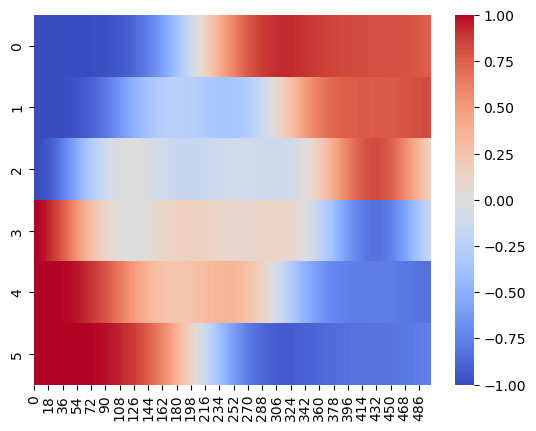

In [15]:
# exact diagonalization:
H = get_Hamiltonian(N,J,U,h_list)
eH = exact_diag(H.as_sparse_matrix(N),T,t_step)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])
ref_state = []

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    ref_state.append(q.time_evolution(eH))
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_4456\3608486987.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


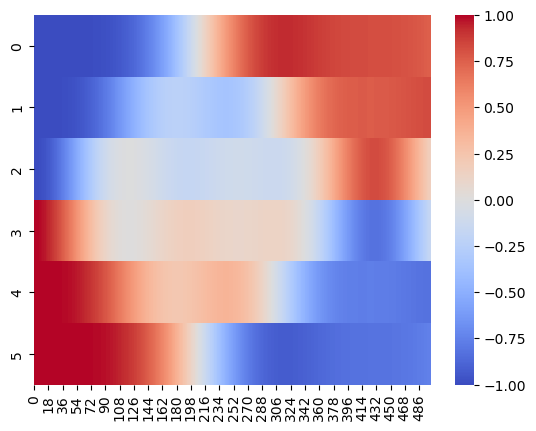

In [16]:
# basic trotter
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
eH = basic_trotter(H_list,T,t_step,N)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])
basic_state = []

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    basic_state.append(q.time_evolution(eH))
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_4456\3537949437.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


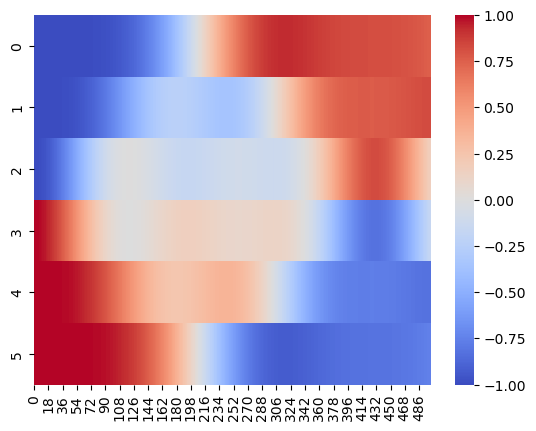

In [17]:
# symetric trotter
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
eH = symmetric_trotter(H_list,T,t_step,N)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])
symmetric_state = []

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    symmetric_state.append(q.time_evolution(eH))
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()

C:\Users\God_Zao\AppData\Local\Temp\ipykernel_956\3283682853.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  XX_disorder_result[h][t] = q.N_half()


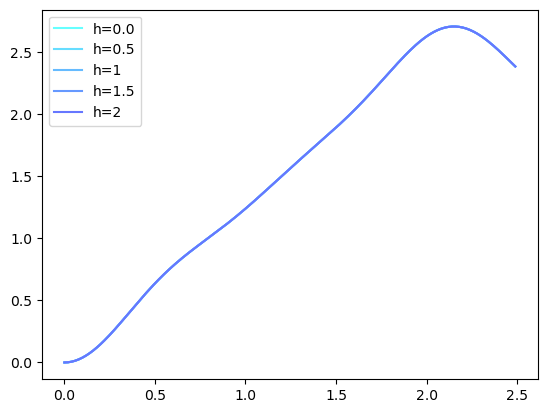

In [13]:
T = 2.5
t_step = 250
h_list = [0.,0.5,1,1.5,2]
#U_list = [0.,0.5,1,1.5,2]
XX_disorder_result = {h:np.zeros(t_step, dtype=float) for h in h_list}
color_list = ['#66ffff','#66ddff','#66bbff','#6699ff','#6677ff']
dt = T/t_step
t_tick = [i*dt for i in range(t_step)]
i=0
for h in h_list:
    hj_list = get_hlist(N,h)
    #H_list = get_trotter_Hamiltonian(N,J,U,hj_list)
    #eH = symmetric_trotter(H_list,T,t_step,N)
    H = get_Hamiltonian(N,J,U,hj_list)
    eH = exact_diag(H.as_sparse_matrix(N),T,t_step)
    q = get_initial_state(N,s)
    XX_disorder_result[h][0] = q.N_half()
    for t in range(1,t_step):
        q.time_evolution(eH)
        XX_disorder_result[h][t] = q.N_half()
    plt.plot(t_tick, XX_disorder_result[h], color = color_list[i],label = f"h={h}")
    i+=1
plt.legend()
plt.show()

C:\Users\God_Zao\AppData\Local\Temp\ipykernel_956\4003372473.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  XXZ_disorder_result[U][t] = q.N_half()


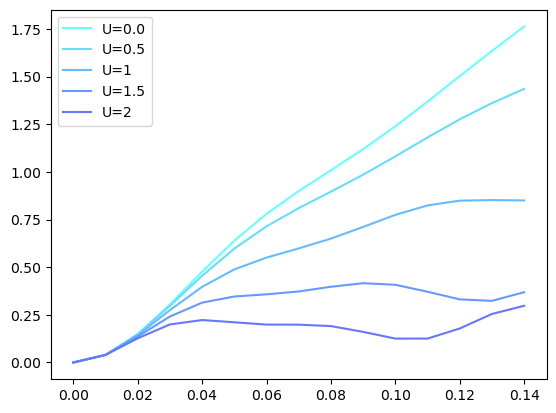

In [21]:
T = 1.5
t_step = 15
U_list = [0.,0.5,1,1.5,2]
h=1.5
XXZ_disorder_result = {U:np.zeros(t_step, dtype=float) for U in U_list}
h_list = get_hlist(N,h)
t_tick = [i*dt for i in range(t_step)]
i=0
for U in U_list:
    H_list = get_trotter_Hamiltonian(N,J,U,h_list)
    eH = symmetric_trotter(H_list,T,t_step,N)
    q = get_initial_state(N,s)
    XXZ_disorder_result[U][0] = q.N_half()
    for t in range(1,t_step):
        q.time_evolution(eH)
        XXZ_disorder_result[U][t] = q.N_half()
    plt.plot(t_tick, XXZ_disorder_result[U], color = color_list[i],label = f"U={U}")
    i+=1
plt.legend()
plt.show()

In [22]:
print(q.q)

  (7, 0)	(-0.01204318292321745+0.00013328616663595139j)
  (21, 0)	(-0.014953526705188727-0.010770190704432882j)
  (19, 0)	(0.015778331132152386-0.01771466927797047j)
  (13, 0)	(0.015778331132152407-0.017714669277970434j)
  (11, 0)	(-0.024698094562810625-0.0032733388824020626j)
  (22, 0)	(0.03214070921393593+0.010022651446800212j)
  (14, 0)	(-0.01606008881371076+0.01642483040016911j)
  (25, 0)	(-0.01576261183175748+0.08283970461368037j)
  (28, 0)	(0.03781408002631141+0.07969898401085022j)
  (26, 0)	(0.01694761293529323-0.041900459561087885j)
  (37, 0)	(0.03214070921393593+0.01002265144680022j)
  (35, 0)	(-0.01606008881371075+0.016424830400169125j)
  (38, 0)	(-0.04904229022811725+0.02381019961633154j)
  (49, 0)	(0.03781408002631134+0.07969898401085025j)
  (41, 0)	(0.01694761293529325-0.04190045956108799j)
  (52, 0)	(0.4577419471049144+0.11288670664544596j)
  (50, 0)	(-0.11775436160611129-0.04182344857226431j)
  (44, 0)	(-0.1177543616061112-0.04182344857226455j)
  (42, 0)	(0.0069196201178

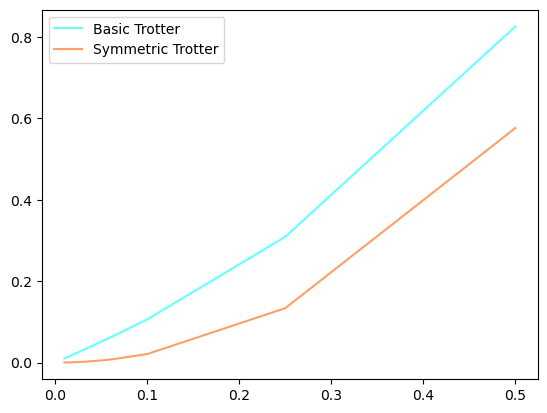

In [10]:
T = 5
t_step = [10,20,50,80,100,150,200,250,400,500]
dt_list = [T/t for t in t_step]
color_list = ['#66ffff','#FF9F66']
basic_dif = []
symm_dif = []
H_ref = get_Hamiltonian(N,J,U,h_list)
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
for i in range(len(t_step)):
    dt = dt_list[i]
    eH_ref = exact_diag(H_ref.as_sparse_matrix(N),T,t_step[i])
    eH_basic = basic_trotter(H_list,T,t_step[i],N)
    eH_symm = symmetric_trotter(H_list,T,t_step[i],N)
    q_ref = get_initial_state(N,s)
    q_basic = get_initial_state(N,s)
    q_symm = get_initial_state(N,s)
    for t in range(t_step[i]):
        q_ref.time_evolution(eH_ref)
        q_basic.time_evolution(eH_basic)
        q_symm.time_evolution(eH_symm)
    basic_dif.append(q_basic.state_distance(q_ref))
    symm_dif.append(q_symm.state_distance(q_ref))
plt.plot(dt_list,basic_dif,color = color_list[0],label = 'Basic Trotter')
plt.plot(dt_list,symm_dif,color = color_list[1],label = 'Symmetric Trotter')
plt.legend()
plt.show()